In [38]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import numpy
import PIL
from PIL import Image
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.optimizers import RMSprop
from keras import backend as K
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate


def euclidean_distance(x, y):
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def conc(vects):
    x, y = vects
    conc1 = concatenate([x,y])
    return conc1

def conc_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],64)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    x = y_pred[:,0:128]
    y = y_pred[:,128:268]
    y_pred1 = euclidean_distance(x,y)
    p = x
    q = y
    p = K.clip(p, K.epsilon(), 1)
    q = K.clip(q, K.epsilon(), 1)
    #y_true1 = y_true[:,0]
    #y_true1 = K.reshape(y_true1,(-1,))
    #print(y_true1)
    #tr_same = y_true[:,1]
    #tr_same = K.reshape(tr_same, (-1,))
    y_true1 = y_true
    tr_same = K.round(y_true/3)
    margin = 1
    test = 0.001*K.sum(p*K.abs(K.log(p)-K.log(q)), axis=1)

    return K.mean((1-tr_same)*(y_true1 * K.square(y_pred1) + (1 - y_true1) * K.square(K.maximum(margin - y_pred1, 0)))
                 + (tr_same)*test)

def triplet_loss(y_true, y_pred):
    x = y_pred[:,0:32]
    y = y_pred[:,32:64]
    y_pred1 = euclidean_distance(x,y)
    y_true1 = y_true
    margin = 1
    return K.mean(y_true1 * K.square(y_pred1) + (1 - y_true1) * K.square(K.maximum(margin - y_pred1, 0)))

def coral_loss(y_true, y_pred):
    x = y_pred[:,0:32]
    y = y_pred[:,32:64]
    n = 32.0
    mul1 = K.dot(K.transpose(x),x)
    one = x*0+1
    mul2 = K.dot(K.transpose(one), x)
    sub = K.dot(K.transpose(mul2), mul2)
    source = (mul1 - (sub)/n)/(n-1)
    
    mul11 = K.dot(K.transpose(y),y)
    mul21 = K.dot(K.transpose(one), y)
    sub1 = K.dot(K.transpose(mul2), mul2)
    n = float(n)
    target = (mul11 - (sub1)/n)/(n-1)
    
    return K.mean(K.dot((source-target),(source-target)))/4*32*32.0
    
    

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)

def create_addi_pairs(x, y):
    pairs = []
    labels = []
    for i in range(0,10):
        k1 = random.randrange(0,x.shape[0])
        for j in range(0,5):
            k2 = random.randrange(0, y.shape[0])
            pairs+= [[x[k1],y[k2]]]
            labels += [3]
    return np.array(pairs), np.array(labels)
             
            
def create_base_network():
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(16, input_shape=(10,), activation='relu'))
    seq.add(Dense(32, activation='relu'))
    seq.add(Dense(32, activation='relu'))
    return seq


def compute_accuracy(predictions, labels):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return labels[predictions.ravel() < 0.5].mean()



In [2]:
import scipy.io
mat = scipy.io.loadmat('/home/aniruddha/Documents/data_10feature.mat')

In [3]:
arr = mat['TR2_10feature']
arr = np.array(arr)
arr = arr.reshape(-1)
print(arr.shape)

(14,)


In [4]:
X_train = []
for i in range(0,14):
    for j in range(0,arr[i].shape[0]):
        X_train.append(arr[i][j])
X_train = np.array(X_train)
print(X_train.shape)

(2621, 10)


In [5]:
y_train = []
for i in range(0,arr.shape[0]):
    for j in range(0,arr[i].shape[0]):
        y_train.append(i)
y_train = np.array(y_train)
print(y_train.shape)
print(y_train[1])

(2621,)
0


In [6]:
arr1 = mat['TS2_10feature']
arr1 = np.array(arr1)
arr1 = arr1.reshape(-1)
print(arr1.shape)

(14,)


In [7]:
X_test = []
for i in range(0,14):
    for j in range(0,arr1[i].shape[0]):
        X_test.append(arr1[i][j])
X_test = np.array(X_test)
print(X_test.shape)

(627, 10)


In [8]:
y_test = []
for i in range(0,arr1.shape[0]):
    for j in range(0,arr1[i].shape[0]):
        y_test.append(i)
y_test = np.array(y_test)
print(y_test.shape)
print(y_test[1])

(627,)
0


In [9]:
arr2 = mat['TS1_10feature']
arr2 = np.array(arr2)
arr2 = arr2.reshape(-1)
print(arr2.shape)

(14,)


In [10]:
X_test1 = []
for i in range(0,14):
    for j in range(0,arr2[i].shape[0]):
        X_test1.append(arr2[i][j])
X_test1 = np.array(X_test1)
print(X_test1.shape)

(1252, 10)


In [11]:
y_test1 = []
for i in range(0,arr2.shape[0]):
    for j in range(0,arr2[i].shape[0]):
        y_test1.append(i)
y_test1 = np.array(y_test1)
print(y_test1.shape)
print(y_test1[1])

(1252,)
0


In [12]:
print(X_train.max())
print(X_test.max())
print(X_test1.max())

9499
7890
6804


In [13]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_test1 = X_test1.astype('float32')

In [14]:
X_train = X_train/10000
X_test = X_test/10000
X_test1 = X_test1/10000

In [15]:
print(X_train.max())
print(X_test.max())
print(X_test1.max())

0.9499
0.789
0.6804


In [16]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(10)]
tr_pairs, tr_y = create_pairs(X_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(10)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

In [17]:
tr1_pairs, tr1_y = create_addi_pairs(X_train, X_test1)

In [18]:
print(tr_pairs.shape)
print(te_pairs.shape)
print(tr1_pairs.shape)

(1640, 2, 10)
(340, 2, 10)
(50, 2, 10)


In [39]:

# network definition
input_dim=X_train.shape[1:]
base_network = create_base_network()

input_a = Input(shape=input_dim)
input_b = Input(shape=input_dim)

#input_a=K.reshape(input_a,(28,28,1))
#input_b=K.reshape(input_b,(28,28,1))
# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
print(input_b.shape)

(?, 10)


In [40]:
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(conc, output_shape=conc_shape)([processed_a, processed_b])
print(distance.shape)

model = Model(input=[input_a, input_b], output=distance)

(?, 64)


/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("la..., inputs=[<tf.Tenso...)`
  import sys


In [41]:
test_model = Model(input = input_a, output = processed_a)

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


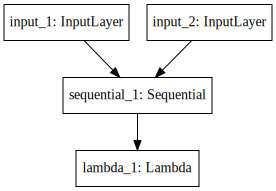

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

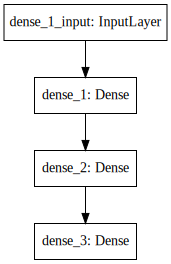

In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(base_network).create(prog='dot', format='svg'))

In [42]:
# train
rms = RMSprop()
for i in range(0,50):
     model.compile(loss=triplet_loss, optimizer=rms)
     model.fit([tr_pairs[:,0], tr_pairs[:, 1]], tr_y, validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y), batch_size=32, nb_epoch=1)
     model.compile(loss=coral_loss, optimizer=rms)
     model.fit([tr1_pairs[:,0], tr1_pairs[:, 1]], tr1_y, batch_size=32, nb_epoch=1)
        

/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 1640 samples, validate on 340 samples
Epoch 1/1
1640/1640 [==============================] - 3s 2ms/step - loss: 0.2864 - val_loss: 0.1801


/home/aniruddha/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/1
50/50 [==============================] - 2s 45ms/step - loss: 3.4276
Train on 1640 samples, validate on 340 samples
Epoch 1/1
1640/1640 [==============================] - 3s 2ms/step - loss: 0.1593 - val_loss: 0.1369
Epoch 1/1
50/50 [==============================] - 3s 57ms/step - loss: 41.7135
Train on 1640 samples, validate on 340 samples
Epoch 1/1
1640/1640 [==============================] - 4s 2ms/step - loss: 0.1102 - val_loss: 0.1047
Epoch 1/1
50/50 [==============================] - 3s 56ms/step - loss: 45.8087
Train on 1640 samples, validate on 340 samples
Epoch 1/1
1640/1640 [==============================] - 3s 2ms/step - loss: 0.0848 - val_loss: 0.0876
Epoch 1/1
50/50 [==============================] - 2s 46ms/step - loss: 17.2035
Train on 1640 samples, validate on 340 samples
Epoch 1/1
1640/1640 [==============================] - 3s 2ms/step - loss: 0.0790 - val_loss: 0.0829
Epoch 1/1
50/50 [==============================] - 2s 46ms/step - loss: 10.6778
Train on 

In [33]:
%matplotlib inline

from time import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets, decomposition, ensemble, discriminant_analysis, random_projection

In [34]:
def plot_embedding(mu, Y, title=None):
    num_class = 50 # data points per class
#     x_min, x_max = np.min(mu, 0), np.max(mu, 0)
#     mu = (mu - x_min) / (x_max - x_min)
    
#     classes = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18, 19, 
#                20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 39, 40, 42, 43, 44, 45, 46, 48, 49]
    
    classes = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
    data = [[] for i in classes]
    for i, y in enumerate(Y):
        data[classes.index(y)].append(np.array(mu[i]))
            
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'olive', 'orange', 'mediumpurple','pink','grey','mediumgrey','brown']
    l = [i for i in range(14)]
    alphas = 0.3 * np.ones(14)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    font_size = 13
    for i in range(13):
        temp = np.array(data[i])
        l[i] = plt.scatter(temp[:num_class, 0], temp[:num_class, 1], s = 5, c = colors[i], edgecolors = 'face', alpha=alphas[i])
    leg = plt.legend((l[0],l[1],l[2],l[3],l[4],l[5],l[6],l[7],l[8],l[9],l[10],l[11],l[12],l[13]), 
               ('0','1','2','3','4','5','6','7','8','9','10','11','12','13'), loc='center left', bbox_to_anchor=(1, 0.5), fontsize=font_size)
    leg.get_frame().set_linewidth(0.0)
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)

In [29]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_test1 = np_utils.to_categorical(y_test1)
num_classes = 14

In [43]:
print(y_train.shape)
print(y_test.shape)
print(y_test1.shape)

(2621, 14)
(627, 14)
(1252, 14)


In [44]:
num_pixels = 32
num_classes=14

In [45]:
# define baseline model
def baseline_model1():
	# create model
	model = Sequential()
	model.add(Dense(32, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(16, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [46]:
processed_train = test_model.predict(X_train)
processed_test = test_model.predict(X_test)
processed_test1 = test_model.predict(X_test1)

In [47]:
print(processed_test.shape)

(627, 32)


In [48]:

# build the model
model1 = baseline_model1()
# Fit the model
model1.fit(processed_train, y_train, validation_data=(processed_test, y_test), epochs=5000, batch_size=128, verbose=1)
# Final evaluation of the model
scores_train = model1.evaluate(processed_train, y_train, verbose=1)
scores_test = model1.evaluate(processed_test, y_test, verbose=1)


Train on 2621 samples, validate on 627 samples
Epoch 1/5000
2621/2621 [==============================] - 6s 2ms/step - loss: 2.6344 - acc: 0.1164 - val_loss: 2.6272 - val_acc: 0.0989
Epoch 2/5000
2621/2621 [==============================] - 0s 24us/step - loss: 2.6143 - acc: 0.1507 - val_loss: 2.5921 - val_acc: 0.1962
Epoch 3/5000
2621/2621 [==============================] - 0s 20us/step - loss: 2.5524 - acc: 0.1896 - val_loss: 2.4912 - val_acc: 0.1962
Epoch 4/5000
2621/2621 [==============================] - 0s 18us/step - loss: 2.4056 - acc: 0.2255 - val_loss: 2.2963 - val_acc: 0.2807
Epoch 5/5000
2621/2621 [==============================] - 0s 19us/step - loss: 2.1876 - acc: 0.2709 - val_loss: 2.0654 - val_acc: 0.2855
Epoch 6/5000
2621/2621 [==============================] - 0s 18us/step - loss: 1.9738 - acc: 0.2701 - val_loss: 1.8589 - val_acc: 0.3381
Epoch 7/5000
2621/2621 [==============================] - 0s 19us/step - loss: 1.7782 - acc: 0.3777 - val_loss: 1.6637 - val_acc: 0.

2621/2621 [==============================] - 0s 15us/step - loss: 0.5999 - acc: 0.7772 - val_loss: 0.6102 - val_acc: 0.7751
Epoch 61/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.5982 - acc: 0.7760 - val_loss: 0.6027 - val_acc: 0.7735
Epoch 62/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.5962 - acc: 0.7749 - val_loss: 0.6034 - val_acc: 0.7703
Epoch 63/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.5945 - acc: 0.7772 - val_loss: 0.5917 - val_acc: 0.7735
Epoch 64/5000
2621/2621 [==============================] - 0s 33us/step - loss: 0.5926 - acc: 0.7749 - val_loss: 0.5958 - val_acc: 0.7735
Epoch 65/5000
2621/2621 [==============================] - 0s 32us/step - loss: 0.5920 - acc: 0.7772 - val_loss: 0.5963 - val_acc: 0.7719
Epoch 66/5000
2621/2621 [==============================] - 0s 29us/step - loss: 0.5913 - acc: 0.7764 - val_loss: 0.6014 - val_acc: 0.7671
Epoch 67/5000
2621/2621 [=======================

2621/2621 [==============================] - 0s 26us/step - loss: 0.5353 - acc: 0.7902 - val_loss: 0.5489 - val_acc: 0.7815
Epoch 179/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.5320 - acc: 0.7886 - val_loss: 0.5522 - val_acc: 0.7799
Epoch 180/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.5337 - acc: 0.7848 - val_loss: 0.5517 - val_acc: 0.7879
Epoch 181/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.5318 - acc: 0.7909 - val_loss: 0.5555 - val_acc: 0.7831
Epoch 182/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.5333 - acc: 0.7898 - val_loss: 0.5511 - val_acc: 0.7863
Epoch 183/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.5342 - acc: 0.7806 - val_loss: 0.5582 - val_acc: 0.7815
Epoch 184/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.5353 - acc: 0.7856 - val_loss: 0.5505 - val_acc: 0.7879
Epoch 185/5000
2621/2621 [================

2621/2621 [==============================] - 0s 19us/step - loss: 0.5297 - acc: 0.7890 - val_loss: 0.5426 - val_acc: 0.7943
Epoch 238/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.5280 - acc: 0.7821 - val_loss: 0.5454 - val_acc: 0.7815
Epoch 239/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.5254 - acc: 0.7932 - val_loss: 0.5403 - val_acc: 0.7911
Epoch 240/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.5255 - acc: 0.7898 - val_loss: 0.5429 - val_acc: 0.7927
Epoch 241/5000
2621/2621 [==============================] - 0s 33us/step - loss: 0.5255 - acc: 0.7917 - val_loss: 0.5433 - val_acc: 0.7863
Epoch 242/5000
2621/2621 [==============================] - 0s 31us/step - loss: 0.5237 - acc: 0.7902 - val_loss: 0.5387 - val_acc: 0.7879
Epoch 243/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.5229 - acc: 0.7936 - val_loss: 0.5447 - val_acc: 0.7847
Epoch 244/5000
2621/2621 [================

2621/2621 [==============================] - 0s 17us/step - loss: 0.5161 - acc: 0.7989 - val_loss: 0.5379 - val_acc: 0.7959
Epoch 297/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.5173 - acc: 0.7924 - val_loss: 0.5347 - val_acc: 0.8006
Epoch 298/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.5157 - acc: 0.7970 - val_loss: 0.5376 - val_acc: 0.7879
Epoch 299/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.5192 - acc: 0.7905 - val_loss: 0.5356 - val_acc: 0.7974
Epoch 300/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.5180 - acc: 0.7944 - val_loss: 0.5392 - val_acc: 0.7831
Epoch 301/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.5165 - acc: 0.7921 - val_loss: 0.5342 - val_acc: 0.7879
Epoch 302/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.5144 - acc: 0.7951 - val_loss: 0.5371 - val_acc: 0.7895
Epoch 303/5000
2621/2621 [================

2621/2621 [==============================] - 0s 23us/step - loss: 0.5109 - acc: 0.7986 - val_loss: 0.5273 - val_acc: 0.7911
Epoch 356/5000
2621/2621 [==============================] - 0s 32us/step - loss: 0.5082 - acc: 0.7986 - val_loss: 0.5244 - val_acc: 0.7943
Epoch 357/5000
2621/2621 [==============================] - 0s 29us/step - loss: 0.5091 - acc: 0.7951 - val_loss: 0.5315 - val_acc: 0.7959
Epoch 358/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.5105 - acc: 0.7974 - val_loss: 0.5289 - val_acc: 0.8006
Epoch 359/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.5106 - acc: 0.7936 - val_loss: 0.5242 - val_acc: 0.8006
Epoch 360/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.5130 - acc: 0.7940 - val_loss: 0.5271 - val_acc: 0.7974
Epoch 361/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.5085 - acc: 0.7978 - val_loss: 0.5237 - val_acc: 0.7974
Epoch 362/5000
2621/2621 [================

2621/2621 [==============================] - 0s 32us/step - loss: 0.4974 - acc: 0.8058 - val_loss: 0.5176 - val_acc: 0.8070
Epoch 415/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.5003 - acc: 0.8024 - val_loss: 0.5247 - val_acc: 0.8150
Epoch 416/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.4977 - acc: 0.8039 - val_loss: 0.5215 - val_acc: 0.8102
Epoch 417/5000
2621/2621 [==============================] - 0s 33us/step - loss: 0.4982 - acc: 0.7997 - val_loss: 0.5114 - val_acc: 0.8054
Epoch 418/5000
2621/2621 [==============================] - 0s 30us/step - loss: 0.4974 - acc: 0.8027 - val_loss: 0.5195 - val_acc: 0.8086
Epoch 419/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.5019 - acc: 0.8016 - val_loss: 0.5111 - val_acc: 0.8054
Epoch 420/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.4981 - acc: 0.8062 - val_loss: 0.5119 - val_acc: 0.8102
Epoch 421/5000
2621/2621 [================

2621/2621 [==============================] - 0s 19us/step - loss: 0.4770 - acc: 0.8165 - val_loss: 0.4915 - val_acc: 0.8118
Epoch 474/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.4811 - acc: 0.8130 - val_loss: 0.4889 - val_acc: 0.8230
Epoch 475/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.4751 - acc: 0.8077 - val_loss: 0.4883 - val_acc: 0.8118
Epoch 476/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.4740 - acc: 0.8123 - val_loss: 0.4930 - val_acc: 0.8134
Epoch 477/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.4722 - acc: 0.8157 - val_loss: 0.4821 - val_acc: 0.8166
Epoch 478/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.4698 - acc: 0.8157 - val_loss: 0.4912 - val_acc: 0.8054
Epoch 479/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.4702 - acc: 0.8150 - val_loss: 0.4831 - val_acc: 0.8198
Epoch 480/5000
2621/2621 [================

2621/2621 [==============================] - 0s 17us/step - loss: 0.4338 - acc: 0.8451 - val_loss: 0.4473 - val_acc: 0.8325
Epoch 533/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.4302 - acc: 0.8382 - val_loss: 0.4412 - val_acc: 0.8501
Epoch 534/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.4314 - acc: 0.8462 - val_loss: 0.4469 - val_acc: 0.8389
Epoch 535/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.4318 - acc: 0.8413 - val_loss: 0.4390 - val_acc: 0.8437
Epoch 536/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.4312 - acc: 0.8394 - val_loss: 0.4413 - val_acc: 0.8501
Epoch 537/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.4304 - acc: 0.8447 - val_loss: 0.4383 - val_acc: 0.8437
Epoch 538/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.4297 - acc: 0.8417 - val_loss: 0.4397 - val_acc: 0.8421
Epoch 539/5000
2621/2621 [================

2621/2621 [==============================] - 0s 17us/step - loss: 0.3823 - acc: 0.8600 - val_loss: 0.3884 - val_acc: 0.8596
Epoch 592/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.3810 - acc: 0.8611 - val_loss: 0.3916 - val_acc: 0.8676
Epoch 593/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.3821 - acc: 0.8630 - val_loss: 0.3931 - val_acc: 0.8628
Epoch 594/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.3799 - acc: 0.8623 - val_loss: 0.3918 - val_acc: 0.8596
Epoch 595/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.3797 - acc: 0.8630 - val_loss: 0.3938 - val_acc: 0.8692
Epoch 596/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.3820 - acc: 0.8691 - val_loss: 0.3894 - val_acc: 0.8692
Epoch 597/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.3824 - acc: 0.8600 - val_loss: 0.3879 - val_acc: 0.8660
Epoch 598/5000
2621/2621 [================

2621/2621 [==============================] - 0s 29us/step - loss: 0.3484 - acc: 0.8745 - val_loss: 0.3581 - val_acc: 0.8676
Epoch 651/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.3514 - acc: 0.8657 - val_loss: 0.3536 - val_acc: 0.8772
Epoch 652/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.3481 - acc: 0.8707 - val_loss: 0.3558 - val_acc: 0.8772
Epoch 653/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.3537 - acc: 0.8714 - val_loss: 0.3615 - val_acc: 0.8708
Epoch 654/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.3476 - acc: 0.8691 - val_loss: 0.3496 - val_acc: 0.8772
Epoch 655/5000
2621/2621 [==============================] - 0s 29us/step - loss: 0.3452 - acc: 0.8722 - val_loss: 0.3546 - val_acc: 0.8804
Epoch 656/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.3449 - acc: 0.8733 - val_loss: 0.3546 - val_acc: 0.8756
Epoch 657/5000
2621/2621 [================

2621/2621 [==============================] - 0s 19us/step - loss: 0.3309 - acc: 0.8771 - val_loss: 0.3310 - val_acc: 0.8836
Epoch 710/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.3304 - acc: 0.8760 - val_loss: 0.3340 - val_acc: 0.8900
Epoch 711/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.3314 - acc: 0.8760 - val_loss: 0.3299 - val_acc: 0.8852
Epoch 712/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.3307 - acc: 0.8771 - val_loss: 0.3429 - val_acc: 0.8756
Epoch 713/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.3273 - acc: 0.8764 - val_loss: 0.3322 - val_acc: 0.8868
Epoch 714/5000
2621/2621 [==============================] - 0s 29us/step - loss: 0.3315 - acc: 0.8764 - val_loss: 0.3311 - val_acc: 0.8852
Epoch 715/5000
2621/2621 [==============================] - 0s 31us/step - loss: 0.3277 - acc: 0.8760 - val_loss: 0.3359 - val_acc: 0.8772
Epoch 716/5000
2621/2621 [================

2621/2621 [==============================] - 0s 17us/step - loss: 0.3200 - acc: 0.8771 - val_loss: 0.3155 - val_acc: 0.8931
Epoch 769/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.3187 - acc: 0.8825 - val_loss: 0.3289 - val_acc: 0.8884
Epoch 770/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.3208 - acc: 0.8764 - val_loss: 0.3233 - val_acc: 0.8900
Epoch 771/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.3275 - acc: 0.8783 - val_loss: 0.3168 - val_acc: 0.8915
Epoch 772/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.3299 - acc: 0.8771 - val_loss: 0.3202 - val_acc: 0.8931
Epoch 773/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.3211 - acc: 0.8787 - val_loss: 0.3184 - val_acc: 0.8915
Epoch 774/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.3180 - acc: 0.8844 - val_loss: 0.3170 - val_acc: 0.8979
Epoch 775/5000
2621/2621 [================

2621/2621 [==============================] - 0s 28us/step - loss: 0.3158 - acc: 0.8829 - val_loss: 0.3097 - val_acc: 0.8963
Epoch 828/5000
2621/2621 [==============================] - 0s 29us/step - loss: 0.3112 - acc: 0.8825 - val_loss: 0.3107 - val_acc: 0.8900
Epoch 829/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.3131 - acc: 0.8821 - val_loss: 0.3080 - val_acc: 0.8900
Epoch 830/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.3121 - acc: 0.8821 - val_loss: 0.3147 - val_acc: 0.8915
Epoch 831/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.3194 - acc: 0.8806 - val_loss: 0.3103 - val_acc: 0.8947
Epoch 832/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.3136 - acc: 0.8829 - val_loss: 0.3033 - val_acc: 0.9027
Epoch 833/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.3115 - acc: 0.8840 - val_loss: 0.3107 - val_acc: 0.8947
Epoch 834/5000
2621/2621 [================

2621/2621 [==============================] - 0s 34us/step - loss: 0.3083 - acc: 0.8844 - val_loss: 0.3061 - val_acc: 0.8836
Epoch 887/5000
2621/2621 [==============================] - 0s 31us/step - loss: 0.3112 - acc: 0.8813 - val_loss: 0.2986 - val_acc: 0.8931
Epoch 888/5000
2621/2621 [==============================] - 0s 29us/step - loss: 0.3093 - acc: 0.8810 - val_loss: 0.2980 - val_acc: 0.8931
Epoch 889/5000
2621/2621 [==============================] - 0s 29us/step - loss: 0.3080 - acc: 0.8855 - val_loss: 0.3050 - val_acc: 0.8884
Epoch 890/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.3075 - acc: 0.8867 - val_loss: 0.3010 - val_acc: 0.8931
Epoch 891/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.3075 - acc: 0.8836 - val_loss: 0.3021 - val_acc: 0.8900
Epoch 892/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.3083 - acc: 0.8817 - val_loss: 0.2998 - val_acc: 0.8931
Epoch 893/5000
2621/2621 [================

2621/2621 [==============================] - 0s 35us/step - loss: 0.3039 - acc: 0.8836 - val_loss: 0.2974 - val_acc: 0.8884
Epoch 946/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.3030 - acc: 0.8874 - val_loss: 0.2990 - val_acc: 0.8900
Epoch 947/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.3030 - acc: 0.8863 - val_loss: 0.2965 - val_acc: 0.8900
Epoch 948/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.3028 - acc: 0.8855 - val_loss: 0.2981 - val_acc: 0.8868
Epoch 949/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.3062 - acc: 0.8890 - val_loss: 0.3023 - val_acc: 0.8836
Epoch 950/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.3061 - acc: 0.8871 - val_loss: 0.2938 - val_acc: 0.8947
Epoch 951/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.3030 - acc: 0.8863 - val_loss: 0.2943 - val_acc: 0.8979
Epoch 952/5000
2621/2621 [================

2621/2621 [==============================] - 0s 16us/step - loss: 0.3038 - acc: 0.8867 - val_loss: 0.2974 - val_acc: 0.8868
Epoch 1005/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.3008 - acc: 0.8867 - val_loss: 0.3047 - val_acc: 0.8740
Epoch 1006/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.3033 - acc: 0.8836 - val_loss: 0.2927 - val_acc: 0.8979
Epoch 1007/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2995 - acc: 0.8890 - val_loss: 0.2930 - val_acc: 0.8915
Epoch 1008/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.3019 - acc: 0.8863 - val_loss: 0.2925 - val_acc: 0.9011
Epoch 1009/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.3022 - acc: 0.8867 - val_loss: 0.3007 - val_acc: 0.8931
Epoch 1010/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.3039 - acc: 0.8867 - val_loss: 0.2977 - val_acc: 0.8931
Epoch 1011/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 15us/step - loss: 0.2958 - acc: 0.8878 - val_loss: 0.2855 - val_acc: 0.8979
Epoch 1121/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2997 - acc: 0.8890 - val_loss: 0.2917 - val_acc: 0.8772
Epoch 1122/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.3014 - acc: 0.8859 - val_loss: 0.2920 - val_acc: 0.8788
Epoch 1123/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2998 - acc: 0.8882 - val_loss: 0.2913 - val_acc: 0.8820
Epoch 1124/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2948 - acc: 0.8890 - val_loss: 0.2821 - val_acc: 0.9011
Epoch 1125/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2945 - acc: 0.8905 - val_loss: 0.2842 - val_acc: 0.9011
Epoch 1126/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2953 - acc: 0.8878 - val_loss: 0.2890 - val_acc: 0.8900
Epoch 1127/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 29us/step - loss: 0.2943 - acc: 0.8878 - val_loss: 0.2835 - val_acc: 0.8963
Epoch 1237/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.2932 - acc: 0.8909 - val_loss: 0.2859 - val_acc: 0.8979
Epoch 1238/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2917 - acc: 0.8913 - val_loss: 0.2836 - val_acc: 0.8963
Epoch 1239/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.2968 - acc: 0.8886 - val_loss: 0.2882 - val_acc: 0.8820
Epoch 1240/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.2941 - acc: 0.8874 - val_loss: 0.2826 - val_acc: 0.8931
Epoch 1241/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.2924 - acc: 0.8909 - val_loss: 0.2868 - val_acc: 0.8836
Epoch 1242/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2926 - acc: 0.8886 - val_loss: 0.2807 - val_acc: 0.8963
Epoch 1243/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 25us/step - loss: 0.2879 - acc: 0.8920 - val_loss: 0.2793 - val_acc: 0.8995
Epoch 1353/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2893 - acc: 0.8894 - val_loss: 0.2780 - val_acc: 0.8931
Epoch 1354/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2893 - acc: 0.8897 - val_loss: 0.2836 - val_acc: 0.8947
Epoch 1355/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.2910 - acc: 0.8916 - val_loss: 0.2807 - val_acc: 0.9011
Epoch 1356/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.2904 - acc: 0.8932 - val_loss: 0.2826 - val_acc: 0.8915
Epoch 1357/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.2876 - acc: 0.8901 - val_loss: 0.2792 - val_acc: 0.9043
Epoch 1358/5000
2621/2621 [==============================] - 0s 31us/step - loss: 0.2919 - acc: 0.8890 - val_loss: 0.2790 - val_acc: 0.8947
Epoch 1359/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 15us/step - loss: 0.2868 - acc: 0.8894 - val_loss: 0.2803 - val_acc: 0.8900
Epoch 1469/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2858 - acc: 0.8924 - val_loss: 0.2802 - val_acc: 0.8963
Epoch 1470/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2869 - acc: 0.8920 - val_loss: 0.2758 - val_acc: 0.9043
Epoch 1471/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2886 - acc: 0.8905 - val_loss: 0.2835 - val_acc: 0.8947
Epoch 1472/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2864 - acc: 0.8928 - val_loss: 0.2755 - val_acc: 0.8979
Epoch 1473/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2845 - acc: 0.8947 - val_loss: 0.2805 - val_acc: 0.8979
Epoch 1474/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2854 - acc: 0.8905 - val_loss: 0.2793 - val_acc: 0.8900
Epoch 1475/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 14us/step - loss: 0.2826 - acc: 0.8947 - val_loss: 0.2783 - val_acc: 0.8931
Epoch 1585/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2827 - acc: 0.8947 - val_loss: 0.2740 - val_acc: 0.8947
Epoch 1586/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2811 - acc: 0.8936 - val_loss: 0.2849 - val_acc: 0.8947
Epoch 1587/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.2825 - acc: 0.8936 - val_loss: 0.2740 - val_acc: 0.8995
Epoch 1588/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.2819 - acc: 0.8939 - val_loss: 0.2754 - val_acc: 0.8979
Epoch 1589/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.2826 - acc: 0.8951 - val_loss: 0.2722 - val_acc: 0.9011
Epoch 1590/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2827 - acc: 0.8947 - val_loss: 0.2811 - val_acc: 0.8963
Epoch 1591/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 18us/step - loss: 0.2834 - acc: 0.8939 - val_loss: 0.2711 - val_acc: 0.8947
Epoch 1701/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2809 - acc: 0.8943 - val_loss: 0.2713 - val_acc: 0.9027
Epoch 1702/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.2799 - acc: 0.8955 - val_loss: 0.2746 - val_acc: 0.8979
Epoch 1703/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.2825 - acc: 0.8936 - val_loss: 0.2802 - val_acc: 0.8931
Epoch 1704/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.2791 - acc: 0.8932 - val_loss: 0.2754 - val_acc: 0.8995
Epoch 1705/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.2819 - acc: 0.8958 - val_loss: 0.2723 - val_acc: 0.8979
Epoch 1706/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.2823 - acc: 0.8932 - val_loss: 0.2752 - val_acc: 0.8915
Epoch 1707/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 22us/step - loss: 0.2831 - acc: 0.8932 - val_loss: 0.2825 - val_acc: 0.8820
Epoch 1817/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2806 - acc: 0.8916 - val_loss: 0.2731 - val_acc: 0.9043
Epoch 1818/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2770 - acc: 0.8970 - val_loss: 0.2690 - val_acc: 0.9059
Epoch 1819/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.2788 - acc: 0.8947 - val_loss: 0.2799 - val_acc: 0.8947
Epoch 1820/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.2784 - acc: 0.8916 - val_loss: 0.2711 - val_acc: 0.9011
Epoch 1821/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.2781 - acc: 0.8977 - val_loss: 0.2717 - val_acc: 0.8995
Epoch 1822/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.2808 - acc: 0.8905 - val_loss: 0.2719 - val_acc: 0.8995
Epoch 1823/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 14us/step - loss: 0.2756 - acc: 0.8932 - val_loss: 0.2723 - val_acc: 0.8963
Epoch 1933/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2774 - acc: 0.8955 - val_loss: 0.2690 - val_acc: 0.9027
Epoch 1934/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2759 - acc: 0.8955 - val_loss: 0.2695 - val_acc: 0.9011
Epoch 1935/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2810 - acc: 0.8936 - val_loss: 0.2706 - val_acc: 0.8931
Epoch 1936/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2779 - acc: 0.8985 - val_loss: 0.2716 - val_acc: 0.8963
Epoch 1937/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2774 - acc: 0.8947 - val_loss: 0.2678 - val_acc: 0.8979
Epoch 1938/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2772 - acc: 0.8928 - val_loss: 0.2695 - val_acc: 0.9027
Epoch 1939/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 14us/step - loss: 0.2839 - acc: 0.8905 - val_loss: 0.2848 - val_acc: 0.8931
Epoch 2049/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2866 - acc: 0.8905 - val_loss: 0.2880 - val_acc: 0.8900
Epoch 2050/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2835 - acc: 0.8913 - val_loss: 0.2719 - val_acc: 0.8947
Epoch 2051/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2795 - acc: 0.8947 - val_loss: 0.2709 - val_acc: 0.9027
Epoch 2052/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2768 - acc: 0.8947 - val_loss: 0.2762 - val_acc: 0.8931
Epoch 2053/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2770 - acc: 0.8958 - val_loss: 0.2703 - val_acc: 0.8979
Epoch 2054/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2763 - acc: 0.8951 - val_loss: 0.2686 - val_acc: 0.8979
Epoch 2055/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 16us/step - loss: 0.2751 - acc: 0.8958 - val_loss: 0.2678 - val_acc: 0.9011
Epoch 2165/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2727 - acc: 0.8981 - val_loss: 0.2725 - val_acc: 0.8995
Epoch 2166/5000
2621/2621 [==============================] - 0s 30us/step - loss: 0.2751 - acc: 0.8951 - val_loss: 0.2659 - val_acc: 0.8947
Epoch 2167/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.2744 - acc: 0.8951 - val_loss: 0.2697 - val_acc: 0.8995
Epoch 2168/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.2733 - acc: 0.8947 - val_loss: 0.2675 - val_acc: 0.8947
Epoch 2169/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.2759 - acc: 0.8970 - val_loss: 0.2686 - val_acc: 0.8963
Epoch 2170/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.2772 - acc: 0.8962 - val_loss: 0.2737 - val_acc: 0.8900
Epoch 2171/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 25us/step - loss: 0.2751 - acc: 0.8981 - val_loss: 0.2760 - val_acc: 0.8900
Epoch 2281/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2767 - acc: 0.8939 - val_loss: 0.2638 - val_acc: 0.8995
Epoch 2282/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2739 - acc: 0.8951 - val_loss: 0.2673 - val_acc: 0.8995
Epoch 2283/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2739 - acc: 0.8966 - val_loss: 0.2810 - val_acc: 0.8804
Epoch 2284/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2774 - acc: 0.8966 - val_loss: 0.2648 - val_acc: 0.9027
Epoch 2285/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.2722 - acc: 0.8951 - val_loss: 0.2651 - val_acc: 0.9011
Epoch 2286/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.2743 - acc: 0.8947 - val_loss: 0.2652 - val_acc: 0.8979
Epoch 2287/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 19us/step - loss: 0.2729 - acc: 0.8981 - val_loss: 0.2669 - val_acc: 0.8979
Epoch 2397/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.2748 - acc: 0.8939 - val_loss: 0.2692 - val_acc: 0.8979
Epoch 2398/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.2749 - acc: 0.8962 - val_loss: 0.2724 - val_acc: 0.9027
Epoch 2399/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2751 - acc: 0.8943 - val_loss: 0.2674 - val_acc: 0.8915
Epoch 2400/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2794 - acc: 0.8974 - val_loss: 0.2777 - val_acc: 0.8804
Epoch 2401/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2754 - acc: 0.8977 - val_loss: 0.2701 - val_acc: 0.8963
Epoch 2402/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2761 - acc: 0.8936 - val_loss: 0.2659 - val_acc: 0.8947
Epoch 2403/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 14us/step - loss: 0.2754 - acc: 0.8947 - val_loss: 0.2713 - val_acc: 0.8915
Epoch 2513/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2739 - acc: 0.8951 - val_loss: 0.2631 - val_acc: 0.9043
Epoch 2514/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2703 - acc: 0.8989 - val_loss: 0.2673 - val_acc: 0.9027
Epoch 2515/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2710 - acc: 0.8977 - val_loss: 0.2656 - val_acc: 0.9011
Epoch 2516/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2698 - acc: 0.8962 - val_loss: 0.2727 - val_acc: 0.8900
Epoch 2517/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2763 - acc: 0.8913 - val_loss: 0.2644 - val_acc: 0.8979
Epoch 2518/5000
2621/2621 [==============================] - 0s 14us/step - loss: 0.2820 - acc: 0.8932 - val_loss: 0.2816 - val_acc: 0.8884
Epoch 2519/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 15us/step - loss: 0.2735 - acc: 0.8928 - val_loss: 0.2732 - val_acc: 0.8884
Epoch 2629/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2720 - acc: 0.8962 - val_loss: 0.2666 - val_acc: 0.9043
Epoch 2630/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2712 - acc: 0.8981 - val_loss: 0.2645 - val_acc: 0.9059
Epoch 2631/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2724 - acc: 0.8939 - val_loss: 0.2616 - val_acc: 0.8963
Epoch 2632/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2722 - acc: 0.8970 - val_loss: 0.2654 - val_acc: 0.9027
Epoch 2633/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2697 - acc: 0.8970 - val_loss: 0.2686 - val_acc: 0.8979
Epoch 2634/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2716 - acc: 0.9000 - val_loss: 0.2621 - val_acc: 0.8995
Epoch 2635/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 16us/step - loss: 0.2688 - acc: 0.8985 - val_loss: 0.2625 - val_acc: 0.8979
Epoch 2745/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2686 - acc: 0.8981 - val_loss: 0.2607 - val_acc: 0.9043
Epoch 2746/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2709 - acc: 0.8970 - val_loss: 0.2610 - val_acc: 0.8979
Epoch 2747/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2687 - acc: 0.9000 - val_loss: 0.2647 - val_acc: 0.8963
Epoch 2748/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2713 - acc: 0.8970 - val_loss: 0.2658 - val_acc: 0.8963
Epoch 2749/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2721 - acc: 0.8958 - val_loss: 0.2667 - val_acc: 0.8931
Epoch 2750/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2726 - acc: 0.8955 - val_loss: 0.2648 - val_acc: 0.9011
Epoch 2751/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 16us/step - loss: 0.2686 - acc: 0.9012 - val_loss: 0.2661 - val_acc: 0.8979
Epoch 2861/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2704 - acc: 0.8981 - val_loss: 0.2646 - val_acc: 0.9011
Epoch 2862/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2748 - acc: 0.8962 - val_loss: 0.2671 - val_acc: 0.9011
Epoch 2863/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2676 - acc: 0.8966 - val_loss: 0.2634 - val_acc: 0.9075
Epoch 2864/5000
2621/2621 [==============================] - 0s 16us/step - loss: 0.2674 - acc: 0.9004 - val_loss: 0.2622 - val_acc: 0.8915
Epoch 2865/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2697 - acc: 0.8977 - val_loss: 0.2597 - val_acc: 0.8995
Epoch 2866/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.2737 - acc: 0.8977 - val_loss: 0.2677 - val_acc: 0.8995
Epoch 2867/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 26us/step - loss: 0.2752 - acc: 0.8962 - val_loss: 0.2683 - val_acc: 0.9043
Epoch 2977/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.2701 - acc: 0.8958 - val_loss: 0.2601 - val_acc: 0.9027
Epoch 2978/5000
2621/2621 [==============================] - 0s 33us/step - loss: 0.2680 - acc: 0.8989 - val_loss: 0.2623 - val_acc: 0.8947
Epoch 2979/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.2708 - acc: 0.8958 - val_loss: 0.2632 - val_acc: 0.9043
Epoch 2980/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.2707 - acc: 0.8966 - val_loss: 0.2585 - val_acc: 0.9011
Epoch 2981/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.2681 - acc: 0.8966 - val_loss: 0.2595 - val_acc: 0.9027
Epoch 2982/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.2676 - acc: 0.8974 - val_loss: 0.2600 - val_acc: 0.9027
Epoch 2983/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 15us/step - loss: 0.2682 - acc: 0.8977 - val_loss: 0.2629 - val_acc: 0.8931
Epoch 3093/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2729 - acc: 0.8977 - val_loss: 0.2631 - val_acc: 0.9027
Epoch 3094/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2688 - acc: 0.8970 - val_loss: 0.2666 - val_acc: 0.8947
Epoch 3095/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2676 - acc: 0.8966 - val_loss: 0.2617 - val_acc: 0.9043
Epoch 3096/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2670 - acc: 0.8989 - val_loss: 0.2611 - val_acc: 0.9043
Epoch 3097/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2702 - acc: 0.8955 - val_loss: 0.2633 - val_acc: 0.9011
Epoch 3098/5000
2621/2621 [==============================] - 0s 15us/step - loss: 0.2684 - acc: 0.8993 - val_loss: 0.2610 - val_acc: 0.9059
Epoch 3099/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 25us/step - loss: 0.2637 - acc: 0.8993 - val_loss: 0.2605 - val_acc: 0.9043
Epoch 3209/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2656 - acc: 0.8989 - val_loss: 0.2597 - val_acc: 0.8995
Epoch 3210/5000
2621/2621 [==============================] - 0s 32us/step - loss: 0.2682 - acc: 0.8974 - val_loss: 0.2628 - val_acc: 0.8915
Epoch 3211/5000
2621/2621 [==============================] - 0s 32us/step - loss: 0.2682 - acc: 0.8993 - val_loss: 0.2642 - val_acc: 0.8947
Epoch 3212/5000
2621/2621 [==============================] - 0s 31us/step - loss: 0.2685 - acc: 0.8970 - val_loss: 0.2658 - val_acc: 0.8947
Epoch 3213/5000
2621/2621 [==============================] - 0s 39us/step - loss: 0.2662 - acc: 0.9000 - val_loss: 0.2620 - val_acc: 0.8963
Epoch 3214/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2682 - acc: 0.8962 - val_loss: 0.2564 - val_acc: 0.9043
Epoch 3215/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 21us/step - loss: 0.2671 - acc: 0.8943 - val_loss: 0.2670 - val_acc: 0.9043
Epoch 3325/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2673 - acc: 0.8977 - val_loss: 0.2643 - val_acc: 0.8979
Epoch 3326/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.2674 - acc: 0.8997 - val_loss: 0.2613 - val_acc: 0.9027
Epoch 3327/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.2670 - acc: 0.8970 - val_loss: 0.2596 - val_acc: 0.8947
Epoch 3328/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2670 - acc: 0.8947 - val_loss: 0.2582 - val_acc: 0.9027
Epoch 3329/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2679 - acc: 0.8962 - val_loss: 0.2603 - val_acc: 0.9011
Epoch 3330/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2672 - acc: 0.8947 - val_loss: 0.2675 - val_acc: 0.8915
Epoch 3331/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 20us/step - loss: 0.2680 - acc: 0.8993 - val_loss: 0.2601 - val_acc: 0.9059
Epoch 3441/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2659 - acc: 0.8951 - val_loss: 0.2667 - val_acc: 0.8995
Epoch 3442/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2701 - acc: 0.8947 - val_loss: 0.2601 - val_acc: 0.9043
Epoch 3443/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.2681 - acc: 0.8977 - val_loss: 0.2587 - val_acc: 0.9011
Epoch 3444/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.2644 - acc: 0.8970 - val_loss: 0.2585 - val_acc: 0.8995
Epoch 3445/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.2681 - acc: 0.8966 - val_loss: 0.2600 - val_acc: 0.8995
Epoch 3446/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2688 - acc: 0.8951 - val_loss: 0.2721 - val_acc: 0.8836
Epoch 3447/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 21us/step - loss: 0.2667 - acc: 0.8974 - val_loss: 0.2584 - val_acc: 0.9027
Epoch 3557/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2697 - acc: 0.8977 - val_loss: 0.2605 - val_acc: 0.9011
Epoch 3558/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.2621 - acc: 0.8989 - val_loss: 0.2590 - val_acc: 0.8979
Epoch 3559/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.2651 - acc: 0.8997 - val_loss: 0.2556 - val_acc: 0.9059
Epoch 3560/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.2699 - acc: 0.8970 - val_loss: 0.2592 - val_acc: 0.8995
Epoch 3561/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.2679 - acc: 0.8955 - val_loss: 0.2568 - val_acc: 0.9027
Epoch 3562/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.2643 - acc: 0.8970 - val_loss: 0.2593 - val_acc: 0.8931
Epoch 3563/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 26us/step - loss: 0.2670 - acc: 0.9027 - val_loss: 0.2622 - val_acc: 0.8963
Epoch 3673/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.2635 - acc: 0.8989 - val_loss: 0.2558 - val_acc: 0.9027
Epoch 3674/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.2678 - acc: 0.8985 - val_loss: 0.2584 - val_acc: 0.8963
Epoch 3675/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.2643 - acc: 0.8981 - val_loss: 0.2563 - val_acc: 0.9011
Epoch 3676/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.2714 - acc: 0.8974 - val_loss: 0.2537 - val_acc: 0.9027
Epoch 3677/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.2653 - acc: 0.8993 - val_loss: 0.2567 - val_acc: 0.9043
Epoch 3678/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.2645 - acc: 0.8985 - val_loss: 0.2558 - val_acc: 0.9027
Epoch 3679/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 27us/step - loss: 0.2638 - acc: 0.9027 - val_loss: 0.2542 - val_acc: 0.9059
Epoch 3789/5000
2621/2621 [==============================] - 0s 29us/step - loss: 0.2632 - acc: 0.9008 - val_loss: 0.2565 - val_acc: 0.8947
Epoch 3790/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.2680 - acc: 0.8985 - val_loss: 0.2621 - val_acc: 0.8947
Epoch 3791/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2656 - acc: 0.8974 - val_loss: 0.2526 - val_acc: 0.9027
Epoch 3792/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.2648 - acc: 0.9016 - val_loss: 0.2546 - val_acc: 0.9043
Epoch 3793/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.2664 - acc: 0.8955 - val_loss: 0.2595 - val_acc: 0.8947
Epoch 3794/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.2658 - acc: 0.9016 - val_loss: 0.2635 - val_acc: 0.8963
Epoch 3795/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 22us/step - loss: 0.2704 - acc: 0.8993 - val_loss: 0.2659 - val_acc: 0.8995
Epoch 3905/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.2692 - acc: 0.8977 - val_loss: 0.2542 - val_acc: 0.8979
Epoch 3906/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.2655 - acc: 0.8958 - val_loss: 0.2653 - val_acc: 0.8931
Epoch 3907/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.2634 - acc: 0.8989 - val_loss: 0.2563 - val_acc: 0.9011
Epoch 3908/5000
2621/2621 [==============================] - 0s 34us/step - loss: 0.2647 - acc: 0.9019 - val_loss: 0.2625 - val_acc: 0.8995
Epoch 3909/5000
2621/2621 [==============================] - 0s 29us/step - loss: 0.2694 - acc: 0.8943 - val_loss: 0.2550 - val_acc: 0.9027
Epoch 3910/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.2623 - acc: 0.8997 - val_loss: 0.2550 - val_acc: 0.9059
Epoch 3911/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 24us/step - loss: 0.2635 - acc: 0.8966 - val_loss: 0.2566 - val_acc: 0.8979
Epoch 4021/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2662 - acc: 0.8932 - val_loss: 0.2556 - val_acc: 0.8979
Epoch 4022/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.2673 - acc: 0.8977 - val_loss: 0.2559 - val_acc: 0.8963
Epoch 4023/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2637 - acc: 0.8989 - val_loss: 0.2558 - val_acc: 0.9043
Epoch 4024/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.2636 - acc: 0.9000 - val_loss: 0.2546 - val_acc: 0.8947
Epoch 4025/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.2632 - acc: 0.8985 - val_loss: 0.2554 - val_acc: 0.9043
Epoch 4026/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2603 - acc: 0.8966 - val_loss: 0.2603 - val_acc: 0.8963
Epoch 4027/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 21us/step - loss: 0.2628 - acc: 0.9000 - val_loss: 0.2565 - val_acc: 0.8947
Epoch 4137/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2599 - acc: 0.8985 - val_loss: 0.2523 - val_acc: 0.9075
Epoch 4138/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.2595 - acc: 0.8985 - val_loss: 0.2536 - val_acc: 0.9027
Epoch 4139/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.2599 - acc: 0.9004 - val_loss: 0.2520 - val_acc: 0.9059
Epoch 4140/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.2620 - acc: 0.9019 - val_loss: 0.2604 - val_acc: 0.8979
Epoch 4141/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.2621 - acc: 0.8989 - val_loss: 0.2561 - val_acc: 0.8963
Epoch 4142/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.2647 - acc: 0.9012 - val_loss: 0.2587 - val_acc: 0.9027
Epoch 4143/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 27us/step - loss: 0.2601 - acc: 0.8981 - val_loss: 0.2568 - val_acc: 0.8995
Epoch 4253/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.2675 - acc: 0.8966 - val_loss: 0.2614 - val_acc: 0.9027
Epoch 4254/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.2605 - acc: 0.8993 - val_loss: 0.2527 - val_acc: 0.9043
Epoch 4255/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2624 - acc: 0.8997 - val_loss: 0.2518 - val_acc: 0.9075
Epoch 4256/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2617 - acc: 0.8955 - val_loss: 0.2476 - val_acc: 0.9075
Epoch 4257/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2627 - acc: 0.9012 - val_loss: 0.2617 - val_acc: 0.8884
Epoch 4258/5000
2621/2621 [==============================] - 0s 20us/step - loss: 0.2652 - acc: 0.8977 - val_loss: 0.2490 - val_acc: 0.9043
Epoch 4259/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 27us/step - loss: 0.2619 - acc: 0.8989 - val_loss: 0.2498 - val_acc: 0.9043
Epoch 4369/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.2615 - acc: 0.9012 - val_loss: 0.2531 - val_acc: 0.8963
Epoch 4370/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.2588 - acc: 0.8970 - val_loss: 0.2516 - val_acc: 0.9059
Epoch 4371/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.2614 - acc: 0.8985 - val_loss: 0.2496 - val_acc: 0.9059
Epoch 4372/5000
2621/2621 [==============================] - 0s 29us/step - loss: 0.2583 - acc: 0.9008 - val_loss: 0.2600 - val_acc: 0.8979
Epoch 4373/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.2624 - acc: 0.9023 - val_loss: 0.2502 - val_acc: 0.9059
Epoch 4374/5000
2621/2621 [==============================] - 0s 27us/step - loss: 0.2639 - acc: 0.9008 - val_loss: 0.2533 - val_acc: 0.8963
Epoch 4375/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 21us/step - loss: 0.2622 - acc: 0.9000 - val_loss: 0.2489 - val_acc: 0.9027
Epoch 4485/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2638 - acc: 0.8981 - val_loss: 0.2515 - val_acc: 0.9011
Epoch 4486/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.2613 - acc: 0.8977 - val_loss: 0.2550 - val_acc: 0.9043
Epoch 4487/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2590 - acc: 0.8997 - val_loss: 0.2518 - val_acc: 0.9043
Epoch 4488/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2592 - acc: 0.9023 - val_loss: 0.2477 - val_acc: 0.9075
Epoch 4489/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2572 - acc: 0.9019 - val_loss: 0.2474 - val_acc: 0.9059
Epoch 4490/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2593 - acc: 0.8997 - val_loss: 0.2577 - val_acc: 0.8979
Epoch 4491/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 32us/step - loss: 0.2626 - acc: 0.9000 - val_loss: 0.2531 - val_acc: 0.8947
Epoch 4601/5000
2621/2621 [==============================] - 0s 28us/step - loss: 0.2584 - acc: 0.8989 - val_loss: 0.2470 - val_acc: 0.8995
Epoch 4602/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2574 - acc: 0.8989 - val_loss: 0.2544 - val_acc: 0.9059
Epoch 4603/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2595 - acc: 0.8981 - val_loss: 0.2547 - val_acc: 0.9011
Epoch 4604/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.2594 - acc: 0.9019 - val_loss: 0.2499 - val_acc: 0.9059
Epoch 4605/5000
2621/2621 [==============================] - 0s 26us/step - loss: 0.2616 - acc: 0.8977 - val_loss: 0.2483 - val_acc: 0.9011
Epoch 4606/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.2578 - acc: 0.8993 - val_loss: 0.2566 - val_acc: 0.8947
Epoch 4607/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 21us/step - loss: 0.2613 - acc: 0.9008 - val_loss: 0.2493 - val_acc: 0.9043
Epoch 4717/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.2585 - acc: 0.8989 - val_loss: 0.2459 - val_acc: 0.9059
Epoch 4718/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.2572 - acc: 0.9035 - val_loss: 0.2466 - val_acc: 0.9107
Epoch 4719/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.2578 - acc: 0.9031 - val_loss: 0.2505 - val_acc: 0.9091
Epoch 4720/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.2583 - acc: 0.9004 - val_loss: 0.2496 - val_acc: 0.9043
Epoch 4721/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2637 - acc: 0.9019 - val_loss: 0.2538 - val_acc: 0.9011
Epoch 4722/5000
2621/2621 [==============================] - 0s 25us/step - loss: 0.2624 - acc: 0.8985 - val_loss: 0.2459 - val_acc: 0.9059
Epoch 4723/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 22us/step - loss: 0.2590 - acc: 0.9023 - val_loss: 0.2457 - val_acc: 0.9043
Epoch 4833/5000
2621/2621 [==============================] - 0s 23us/step - loss: 0.2567 - acc: 0.9016 - val_loss: 0.2604 - val_acc: 0.8900
Epoch 4834/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2611 - acc: 0.8997 - val_loss: 0.2501 - val_acc: 0.9043
Epoch 4835/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2589 - acc: 0.9000 - val_loss: 0.2498 - val_acc: 0.9027
Epoch 4836/5000
2621/2621 [==============================] - 0s 22us/step - loss: 0.2585 - acc: 0.8958 - val_loss: 0.2452 - val_acc: 0.9027
Epoch 4837/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2575 - acc: 0.8993 - val_loss: 0.2483 - val_acc: 0.9075
Epoch 4838/5000
2621/2621 [==============================] - 0s 24us/step - loss: 0.2560 - acc: 0.9016 - val_loss: 0.2495 - val_acc: 0.8979
Epoch 4839/5000
2621/2621 [=========

2621/2621 [==============================] - 0s 19us/step - loss: 0.2585 - acc: 0.8997 - val_loss: 0.2492 - val_acc: 0.9059
Epoch 4949/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2558 - acc: 0.9023 - val_loss: 0.2455 - val_acc: 0.9059
Epoch 4950/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.2579 - acc: 0.8989 - val_loss: 0.2556 - val_acc: 0.8963
Epoch 4951/5000
2621/2621 [==============================] - 0s 18us/step - loss: 0.2573 - acc: 0.9008 - val_loss: 0.2457 - val_acc: 0.9075
Epoch 4952/5000
2621/2621 [==============================] - 0s 19us/step - loss: 0.2548 - acc: 0.9016 - val_loss: 0.2439 - val_acc: 0.9091
Epoch 4953/5000
2621/2621 [==============================] - 0s 17us/step - loss: 0.2548 - acc: 0.9016 - val_loss: 0.2454 - val_acc: 0.9043
Epoch 4954/5000
2621/2621 [==============================] - 0s 21us/step - loss: 0.2548 - acc: 0.8989 - val_loss: 0.2505 - val_acc: 0.9027
Epoch 4955/5000
2621/2621 [=========

In [98]:
# 5000 epochs
# output 32 dimension
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

* Accuracy on training set: 90.88%
* Accuracy on test set: 90.91%


In [99]:
# 5000 epochs
# output 32 dimension
scores_test_target=model1.evaluate(processed_test1, y_test1, verbose=1)
print('* Accuracy on test target set: %0.2f%%' % (100 * scores_test_target[1]))

1252/1252 [==============================] - 0s 92us/step
* Accuracy on test target set: 66.45%


In [62]:
# 5000 epochs
# output dim 16
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

* Accuracy on training set: 88.71%
* Accuracy on test set: 88.36%


In [63]:
# 5000 epochs
# output dim 16
scores_test_target=model1.evaluate(processed_test1, y_test1, verbose=1)
print('* Accuracy on test target set: %0.2f%%' % (100 * scores_test_target[1]))

1252/1252 [==============================] - 0s 82us/step
* Accuracy on test target set: 65.58%


In [113]:
# 5000 epochs
# output 32 dimension
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))

* Accuracy on training set: 92.56%
* Accuracy on test set: 90.91%


In [114]:
# 5000 epochs
# output 32 dimension
scores_test_target=model1.evaluate(processed_test1, y_test1, verbose=1)
print('* Accuracy on test target set: %0.2f%%' % (100 * scores_test_target[1]))

1252/1252 [==============================] - 0s 126us/step
* Accuracy on test target set: 61.26%


In [46]:
# 5000 epochs
# output 5 dimension
# coral + contrastive
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))
scores_test_target=model1.evaluate(processed_test1, y_test1, verbose=1)
print('* Accuracy on test target set: %0.2f%%' % (100 * scores_test_target[1]))

* Accuracy on training set: 85.77%
* Accuracy on test set: 86.92%
1252/1252 [==============================] - 0s 50us/step
* Accuracy on test target set: 63.58%


In [59]:
# 5000 epochs
# output 10 dimension
# coral + contrastive
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))
scores_test_target=model1.evaluate(processed_test1, y_test1, verbose=1)
print('* Accuracy on test target set: %0.2f%%' % (100 * scores_test_target[1]))

* Accuracy on training set: 84.40%
* Accuracy on test set: 82.93%
1252/1252 [==============================] - 0s 64us/step
* Accuracy on test target set: 62.38%


In [70]:
# 5000 epochs
# output 16 dimension
# coral + contrastive
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))
scores_test_target=model1.evaluate(processed_test1, y_test1, verbose=1)
print('* Accuracy on test target set: %0.2f%%' % (100 * scores_test_target[1]))

* Accuracy on training set: 85.62%
* Accuracy on test set: 84.69%
1252/1252 [==============================] - 0s 82us/step
* Accuracy on test target set: 60.54%


In [32]:
# 5000 epochs
# output 32 dimension
# coral + contrastive
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))
scores_test_target=model1.evaluate(processed_test1, y_test1, verbose=1)
print('* Accuracy on test target set: %0.2f%%' % (100 * scores_test_target[1]))

* Accuracy on training set: 90.00%
* Accuracy on test set: 89.79%
1252/1252 [==============================] - 0s 46us/step
* Accuracy on test target set: 67.97%


In [49]:
# 5000 epochs
# output 32 dimension
# coral + contrastive
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))
scores_test_target=model1.evaluate(processed_test1, y_test1, verbose=1)
print('* Accuracy on test target set: %0.2f%%' % (100 * scores_test_target[1]))

* Accuracy on training set: 90.54%
* Accuracy on test set: 90.75%
1252/1252 [==============================] - 0s 47us/step
* Accuracy on test target set: 69.73%


In [82]:
# 5000 epochs
# output 64 dimension
# coral + contrastive
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))
scores_test_target=model1.evaluate(processed_test1, y_test1, verbose=1)
print('* Accuracy on test target set: %0.2f%%' % (100 * scores_test_target[1]))

* Accuracy on training set: 92.71%
* Accuracy on test set: 91.55%
1252/1252 [==============================] - 0s 82us/step
* Accuracy on test target set: 68.69%


In [37]:
# 5000 epochs
# output 64 dimension
# coral + contrastive
print('* Accuracy on training set: %0.2f%%' % (100 * scores_train[1]))
print('* Accuracy on test set: %0.2f%%' % (100 * scores_test[1]))
scores_test_target=model1.evaluate(processed_test1, y_test1, verbose=1)
print('* Accuracy on test target set: %0.2f%%' % (100 * scores_test_target[1]))

* Accuracy on training set: 92.18%
* Accuracy on test set: 91.39%
1252/1252 [==============================] - 0s 35us/step
* Accuracy on test target set: 68.77%
